# Loading and Preprocessing Data with TensorFlow

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

## Datasets

In [2]:
X = tf.range(10)

# Create new dataset from a tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [3]:
# This is equivalent to the above
dataset = tf.data.Dataset.range(10)

# Iterate over the items of a dataset
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [4]:
# Repeat the dataset 3 times and batch it by 7 items
dataset = dataset.repeat(3).batch(7)

# Note: The last batch may be incomplete (there's a parameter to skip it)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [5]:
# Apply a transformation to dataset items
dataset = dataset.map(lambda x: x * 2)

for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [6]:
# Flatten the batches back to single stream of items
dataset = dataset.unbatch()
dataset

<_UnbatchDataset shapes: (), types: tf.int64>

In [7]:
# Filter the items by a predicate
dataset = dataset.filter(lambda x: x < 10)

# Take just first 3 items
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [8]:
# Set the RNG state
tf.random.set_seed(42)

# Build a dataset
dataset = tf.data.Dataset.range(10).repeat(3)

# Shuffle the data using a buffer of size 3 and batch it by 7
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


## Split the California dataset to multiple CSV files

In [9]:
import csv

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Fetch and split the California housing dataset
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# Scale the training data and keep the mean and std aside
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

# Let's assume this is a very large dataset that doesn't fit into memory
#  - then it's typically split into multiple partitions as stored separately
#  - TF then can lazily and in parallel load such a dataset

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    
    # Partition the data
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        
        # Generate new CSV file name
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        
        # Create new partition file
        with open(part_csv, "wt", encoding="utf-8") as f:
            # Crate new CSV writer
            writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            
            # Optionally write the header
            if header is not None and header:
                writer.writerow(header)
                
            # Write all the data rows
            rows = (
                [repr(col) for col in data[row_idx]]
                for row_idx in row_indices
            )
            writer.writerows(rows)
    
    # Return a list of generated CSV file paths
    return filepaths


# Collect the data to be partitioned
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]

# Make a CSV header
header = housing.feature_names + ["MedianHouseValue"]

# Partition and save all the datasets
train_filepaths = save_to_multiple_csv_files(train_data, name_prefix="train", header=header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, name_prefix="valid", header=header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, name_prefix="test", header=header, n_parts=10)

In [10]:
import pandas as pd

# Check out one of the training partition files
pd.read_csv(train_filepaths[0]).head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  3.5214      15.0  3.049945   1.106548      1447.0  1.605993     37.63   
1  5.3275       5.0  6.490060   0.991054      3464.0  3.443340     33.69   
2  3.1000      29.0  7.542373   1.591525      1328.0  2.250847     38.44   
3  7.1736      12.0  6.289003   0.997442      1054.0  2.695652     33.55   
4  2.0549      13.0  5.312457   1.085092      3297.0  2.244384     33.93   

   Longitude  MedianHouseValue  
0    -122.43             1.442  
1    -117.39             1.687  
2    -122.98             1.621  
3    -117.70             2.621  
4    -116.93             0.956

In [11]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

## Building an Input Pipeline

In [12]:
# Build a dataset consisting of all the training partitions
#  - this function also shuffles the filepaths to make all later batches more iid
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

# Show shuffled file paths
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

In [13]:
def load_textline_ds(filepath):
    # Load the CSV data without the header
    return tf.data.TextLineDataset(filepath).skip(1)

# Load `n_readers` items in parallel and mapping them - loading the dataset
n_readers = 5
dataset = filepath_dataset.interleave(load_textline_ds, cycle_length=n_readers)

for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


In [14]:
# Let's try to parse a CSV row
#  - Notice: field 4 is interpreted as string
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [15]:
# An example showing that all the missing fields are replaced by the respective default value
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [16]:
# This example fails because the 5th field is compulsory due to it's defualt `tf.constant([])`
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


In [17]:
# Also the number of fields must match
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [18]:
n_inputs = X_train.shape[-1]
default_values = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]

@tf.function
def preprocess(line):
    # Parse the CSV line
    fields = tf.io.decode_csv(line, record_defaults=default_values)
    # Split the fields to features and target
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    # Return normalized data
    #  - notice that here we use the scaling parameters that must be pre-computed and kept somewhere
    return (x - X_mean) / X_std, y

# Test the preprossing function
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [19]:
# Reset the RNG state
tf.random.set_seed(42)

# Pack all the preprocessing logic above to single action
def read_csv_dataset(
    filepaths,
    repeat=1,
    n_readers=5,
    n_read_threads=None,
    shuffle_buffer_size=10000,
    n_parse_threads=5,
    batch_size=32,
):
    # Prefetching means that TF loads next data in advance while the upstream process still runs
    #  - Upstream here typically means model training which typically runs on a GPU
    #  - So the reasources are well utilized since this runs in parallel on CPUs and the GPU can be 100% utilized
    return (
        tf.data.Dataset
        .list_files(filepaths)
        .repeat(repeat)
        .interleave(load_textline_ds, cycle_length=n_readers, num_parallel_calls=n_read_threads)
        .shuffle(shuffle_buffer_size)
        .map(preprocess, num_parallel_calls=n_parse_threads)
        .batch(batch_size)
        .prefetch(1)
    )

# Test this preprocessing pipeline on the training dataset
train_set = read_csv_dataset(train_filepaths, batch_size=3)

for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [20]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Load all datasets
train_set = read_csv_dataset(train_filepaths, repeat=None)
valid_set = read_csv_dataset(valid_filepaths)
test_set = read_csv_dataset(test_filepaths)

# Build a simple regression model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Train and validate the model on loaded datasets
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10, validation_data=valid_set)

# Evaluate the model on the test dataset
model.evaluate(test_set, steps=len(X_test) // batch_size)

# Make new predictions
# - note: here we could instead just pass `test_set`, Keras would ignore the labels
new_set = test_set.map(lambda X, y: X)
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

Epoch 1/10
362/362 [==============================] - 1s 4ms/step - loss: 1.7443 - val_loss: 1.5302
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.8780 - val_loss: 1.0380
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.7399 - val_loss: 0.7188
Epoch 4/10
362/362 [==============================] - 1s 2ms/step - loss: 0.7234 - val_loss: 0.6914
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6817 - val_loss: 0.8448
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6367 - val_loss: 0.9235
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6032 - val_loss: 0.6490
Epoch 8/10
362/362 [==============================] - 2s 4ms/step - loss: 0.5945 - val_loss: 0.5858
Epoch 9/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5454 - val_loss: 0.5139
Epoch 10/10
161/161 [==============================] - 0s 1ms/step - loss: 0.5101


array([[1.4324219],
       [1.524963 ],
       [2.2890623],
       ...,
       [1.6232221],
       [1.543162 ],
       [2.7742057]], dtype=float32)

In [21]:
# Training hyperparameters
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0

# Example of custom training loop
#  - here the TF dataset takes care of the micro-batching
#  - however, preprocessing is not part of the model and runs on CPUs
#  - this means that it is not as portable as the TF model

for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    
    # Feed the batch forward through the model
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    
    # Compute gradients and make an optimization step
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [22]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define training hyperparameters
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

# Due to `tf.function` both model training and preprocessing is ran by TF (i.e. possibly on the GPU)
@tf.function
def train(model, n_epochs, batch_size=32, n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = read_csv_dataset(
        train_filepaths,
        repeat=n_epochs,
        n_readers=n_readers,
        n_read_threads=n_read_threads,
        shuffle_buffer_size=shuffle_buffer_size,
        n_parse_threads=n_parse_threads,
        batch_size=batch_size
    )
    
    for X_batch, y_batch in train_set:
        
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [23]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define training hyperparameters
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32, n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = read_csv_dataset(
        train_filepaths,
        repeat=n_epochs,
        n_readers=n_readers,
        n_read_threads=n_read_threads,
        shuffle_buffer_size=shuffle_buffer_size,
        n_parse_threads=n_parse_threads,
        batch_size=batch_size,
    )
    
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    
    for X_batch, y_batch in train_set.take(total_steps):
        
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


In [24]:
# Short description of the `Dataset` API
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` 

## The TFRecord binary format

In [25]:
filepath = os.path.join("data", "my_data.tfrecord")

# Writing data in `TFRecord` format
with tf.io.TFRecordWriter(filepath) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

# Reading a dataset from file(s) in `TFRecord` format
dataset = tf.data.TFRecordDataset(filenames=[filepath])

for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [26]:
filepaths = [os.path.join("data", f"my_test_{i}.tfrecord") for i in range(5)]

# Write some data in TFRecord format into multiple files
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write(f"File {i} record {j}")

# Read multiple TFRecord files in parallel
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)

for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [27]:
filepath = os.path.join("data", "my_compressed.tfrecord")

# Create compression options
options = tf.io.TFRecordOptions(compression_type="GZIP")

# Write some data to compressed TFRecord file
with tf.io.TFRecordWriter(filepath, options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

# Read a dataset from a compressed TFRecord file
dataset = tf.data.TFRecordDataset(filenames=[filepath], compression_type="GZIP")

for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Intro to Protocol Buffers
*TFRecord* file can contain arbitrary binary data. However, it's is quite common to use it in combination with *protobuf*, so let's quickly review it.

Let's start by creating a schema description file `data/person.proto`

In [28]:
%mkdir -p proto

In [29]:
%%writefile proto/person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting proto/person.proto


Compile the `data/person.proto` for *Python*

In [30]:
!protoc proto/person.proto --python_out=. --descriptor_set_out=proto/person.desc --include_imports

In [31]:
!ls proto/person*

proto/person.desc  proto/person.proto  proto/person_pb2.py


In [32]:
import sys

# Add protobuf generated sources to the path
proto_dir = os.path.join(os.curdir, "proto")
if proto_dir not in sys.path:
    sys.path.append(proto_dir)

In [33]:
from person_pb2 import Person

# Create a Person
person = Person(name="Al", id=123, email=["a@b.com"])

# Display the Person
print(person)

name: "Al"
id: 123
email: "a@b.com"



In [34]:
person.name

'Al'

In [35]:
person.name = "Alice"

In [36]:
person.email[0]

'a@b.com'

In [37]:
person.email.append("c@d.com")

In [38]:
# Serialize the object to a byte string
s = person.SerializeToString()
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [39]:
# Create a new Person and parse the byte string (returning the number of bytes read)
person2 = Person()
person2.ParseFromString(s)

27

In [40]:
# Test the deserialization
person == person2

True

#### Custom protobuf

In [41]:
# Parsing a custom protobuf in TF
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source=os.path.join(proto_dir, "person.desc"),
)

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

### TensorFlow Protobufs
The most common of TF's built-in (pre-compiled) protobuf objects is the `Example`.

```protobuf
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [42]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

# Create an `Example` for the Person instance from above
person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }
    )
)

example_path = os.path.join("data", "my_contacts.tfrecord")

# Serialize the example as TFRecord file
with tf.io.TFRecordWriter(example_path) as f:
    f.write(person_example.SerializeToString())
    
# Deserialize the example TFRecord file
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset([example_path]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb4d95ff070>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [43]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [44]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [45]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

#### Putting Images in TFRecords

In [46]:
from sklearn.datasets import load_sample_images

# Load a sample image
img = load_sample_images()["images"][0]

# Plot the image
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [47]:
# Encode the image to JPEG
data = tf.io.encode_jpeg(img)

# Make an Example from the image data
example_with_image = Example(
    features=Features(
        feature={
            "image": Feature(bytes_list=BytesList(value=[data.numpy()]))
        }
    )
)

# Serialize the image into TFRecord
serialized_example = example_with_image.SerializeToString()

# Deserialize the TFRecord back into an image
feature_description = {"image": tf.io.VarLenFeature(tf.string)}
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)

# Decode the JPEG back into origial image
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

# Show the decoded image for comparison
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

#### Putting Tensors and Sparse Tensors in TFRecords

In [48]:
# Make some tensor
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])

# Serializing a tensor
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [49]:
# Deserialize a tensor
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [50]:
# Serialize a sparse tensor
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [51]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [52]:
# Make a dataset that loads data from TFRecord files
#  - also batch them by 10
dataset = tf.data.TFRecordDataset([example_path]).batch(10)

# Parse multiple examples at once
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples, feature_description)

parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb4a6f3cdf0>}

### Handling Sequential Data Using SequenceExample
```protobuf
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

The `SequenceExample` is handy for textual datasets or any other datasets that contain nested lists. For instance an article is composed of sentences, each sentence is a sequence of words. Additionally, an article usually contains some contextual metadata like an author, title, publish date, etc.

In [53]:
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

# Create an example article's context
context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

# Article's content
content = [
    ["When", "shall", "we", "three", "meet", "again", "?"],
    ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"],
]

# Article's comments
comments = [
    ["When", "the", "hurlyburly", "'s", "done", "."],
    ["When", "the", "battle", "'s", "lost", "and", "won", "."],
]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode() for word in words]))

# Make a Feature for each sentence and comment
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
# Compose the SequenceExample representing an article
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(
        feature_list={
            "content": FeatureList(feature=content_features),
            "comments": FeatureList(feature=comments_features),
        }
    )
)

sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [54]:
# Serialize the article example
serialized_sequence_example = sequence_example.SerializeToString()

# Define the feature bindings

context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}

sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

# Deserialize the article
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions
)

parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb4d9512e20>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [55]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [56]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb4d9512280>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb4d94c9100>}

In [57]:
# Variable string lists are best represented by a RaggedTensor
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


## The Features API

In [58]:
# Load California housing dataset
housing_path = os.path.join("datasets", "housing.csv")
housing = pd.read_csv(housing_path)

housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [59]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [60]:
# The median age is column in 1
age_mean, age_std = X_mean[1], X_std[1]

housing_median_age = tf.feature_column.numeric_column("housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x7fb4d9527790>)

In [61]:
median_income = tf.feature_column.numeric_column("median_income")

bucketized_income = tf.feature_column.bucketized_column(median_income, boundaries=[1.5, 3., 4.5, 6.])
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [62]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list("ocean_proximity", ocean_prox_vocab)
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [63]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket("city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [64]:
# Note: age was scaled
bucketized_age = tf.feature_column.bucketized_column(housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.])

age_and_ocean_proximity = tf.feature_column.crossed_column([bucketized_age, ocean_proximity], hash_bucket_size=100)

latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")

bucketized_latitude = tf.feature_column.bucketized_column(latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))

location = tf.feature_column.crossed_column([bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity, dimension=2)

### Using Feature Columns for Parsing

In [65]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [66]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

filepath = os.path.join("datasets", "my_data_with_features.tfrecords")

# Serialize the a subset of the housing data
with tf.io.TFRecordWriter(filepath) as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(
            features=Features(
                feature={
                    "housing_median_age": Feature(float_list=FloatList(value=[x])),
                    "median_house_value": Feature(float_list=FloatList(value=[y])),
                }
            )
        )
        f.write(example.SerializeToString())

        
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    # Separate the targets
    targets = examples.pop("median_house_value")
    return examples, targets

# Load and parse the dataset and also batch it
batch_size = 32
dataset = (
    tf.data.TFRecordDataset(filenames=[filepath])
    .repeat()
    .shuffle(10000)
    .batch(batch_size)
    .map(parse_examples)
)

feature_columns = columns[:-1]

# Build a simple regression model
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=feature_columns),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

# Train the model on the dataset for few epochs
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
362/362 [==============================] - 0s 1ms/step - loss: 3.7619 - accuracy: 0.0016
Epoch 2/5
362/362 [==============================] - 0s 1ms/step - loss: 1.9311 - accuracy: 0.0027
Epoch 3/5
362/362 [==============================] - 0s 930us/step - loss: 1.4434 - accuracy: 0.0026
Epoch 4/5
362/362 [==============================] - 0s 1ms/step - loss: 1.3579 - accuracy: 0.0030
Epoch 5/5
362/362 [==============================] - 0s 1ms/step - loss: 1.3473 - accuracy: 0.0038


In [67]:
some_columns = [ocean_proximity_embed, bucketized_income]

dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.14504611,  0.7563394 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.1119912 ,  0.56957847],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.1119912 ,  0.56957847]], dtype=float32)>

## TF Transform
```python
import tensorflow_transform as tft

def preprocess(inputs):
    # Inputs is a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }
```

## TensorFlow Datasets
TF datasets is a collection of standard datasets directly accessible and usable with TF.

In [68]:
import tensorflow_datasets as tfds

# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32

# Load batched MNIST datasets and split them to training and test sets
#  - `as_supervised=True` flag auto splits the data to features and targets
datasets = tfds.load(name="mnist", batch_size=batch_size, as_supervised=True)
mnist_train, mnist_test = datasets["train"], datasets["test"]

# Build a simple classification model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

# Train the model for few epochs
model.fit(mnist_train, steps_per_epoch=60000 // batch_size, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 32.1418 - accuracy: 0.8416
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 25.9586 - accuracy: 0.8686
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 24.9012 - accuracy: 0.8738
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 24.4328 - accuracy: 0.8759
Epoch 5/5
1875/1875 [==============================] - 2s 960us/step - loss: 23.8487 - accuracy: 0.8784


## TensorFlow Hub

In [69]:
import tensorflow_hub as hub

# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Fetch a Keras layer from TF Hub
hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
    output_shape=[50],
    input_shape=[],
    dtype=tf.string,
)

# Build a model that reuses the TF Hub layer
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [70]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])

# Use the TF Hub layer to embed some sentences
embeddings = hub_layer(sentences)
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       

## Exercises

### Fashion MNIST dataset

In [109]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Fetch and split the Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Split it further to training and validation sets
val_split = 5000
X_valid, X_train = X_train_full[:val_split], X_train_full[val_split:]
y_valid, y_train = y_train_full[:val_split], y_train_full[val_split:]

# Make TF datasets from the training, validation and test sets
#  - also shuffle the training dataset
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))


def create_example(image, label):
    """Make an example containing raw image data and labels as features"""
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

# Test creating an example from the validation set
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [113]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    def filename(index):
        return os.path.join("data", f"{name}.tfrecord-{index:05d}-of-{n_shards:05d}")
    
    paths = [filename(index) for index in range(n_shards)]
    
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
            
    return paths

# Save all datasets into TFRecord files
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

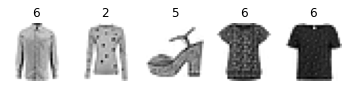

In [114]:
feature_descriptions = {
    "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
}


def preprocess(tfrecord):
    """Parse a `TFRecord` into image and label"""
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
    """Make a MNIST dataset by loading, preprocessing and batching given files"""
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
        
    return (
        dataset.map(preprocess, num_parallel_calls=n_parse_threads)
        .batch(batch_size)
        .prefetch(1)
    )


# Load and preprocess all the MNIST TFRecord datasets
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(train_filepaths)
test_set = mnist_dataset(train_filepaths)

# Show few images from a training batch
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [117]:
from datetime import datetime

# Reset TF session and RNG state
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Custom implementation of normalization
#  - Note: this is soon to be replaced by currently experimental `Normalization` layer
class Standardization(keras.layers.Layer):
    """Layer that after adaptation normalizes a batch of input data"""
    
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())


# Alternative: `keras.layers.experimental.preprocessing.Normalization`
standardization = Standardization(input_shape=[28, 28])

# Adapt the normalization layer on a subset of the training set (100 samples)
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
standardization.adapt(sample_images)

# Build a simple classification model including the pre-trained normalization layer
model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Make a TensorBoard callback
run_label = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join(os.curdir, "logs", "run_{run_label}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch=10)

# Train and validate the model for few epochs
model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 342.3942 - accuracy: 0.8427 - val_loss: 106.1885 - val_accuracy: 0.8749
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 308.4761 - accuracy: 0.8794 - val_loss: 506.1300 - val_accuracy: 0.8963
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 210.8158 - accuracy: 0.8913 - val_loss: 317.1864 - val_accuracy: 0.9043
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 163.8722 - accuracy: 0.9007 - val_loss: 146.7453 - val_accuracy: 0.9086
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 145.4592 - accuracy: 0.9077 - val_loss: 68.4470 - val_accuracy: 0.9159
